In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# A11 Results, short dataset

In [2]:
#Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
# Function to calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [3]:
def generate_hourly_metrics(
    path: str,
    months: [int],
    days: [int],
    month_idx: int,
    mean: int,
    std: int,
    save=False,
    input_days=7
):
    """
    Month: [0,11]
    Day: [0,6]
    day_of_week: {4: 0, 5: 1, 6: 2, 0: 3, 1: 4, 2: 5, 3: 6}
    """
    months_map = {1: "January", 
                 2: "February",
                 3: "March",
                 4: "April",
                 5: "May",
                 6: "June",
                 7: "July",
                 8: "August",
                 9: "September",
                 10: "October",
                 11: "November",
                 12: "December",}
    days_map = {0: "Monday",
                1:"Tuesday",
                2:"Wednesday",
                3:"Thursday",
                4:"Friday",
                5:"Saturday",
                6:"Sunday",}
    #Function to calculate RMSE
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Function to calculate MAPE
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    observed = []
    predicted = []

    eia_data = pd.read_csv(
        "../data/final_tables/erco_2023_andcomposite/erco_2023_andcomposite.csv"
    )
    data_2023 = eia_data[(eia_data["2023"] == 1) & (eia_data["year"] == 2023)]

    actual_months = [m + 1 for m in months]
    df = data_2023[data_2023["month"].isin(actual_months)][
        ["day_of_week", "hour", "Demand Forecast (MWh)"]
    ]
    df.rename(
        columns={
           "Demand Forecast (MWh)": "eia_forecast" 
        },
        inplace=True
    
    )
    
    with open(path, "r") as file:
        data = json.load(file)

        for month in months:
            # Step 1: find start index
            start_idx = 0 if month != 11 else input_days
            while True:
                source = data["source_readings"][start_idx]
                m = source[0][month_idx]
                if m == month:
                    break
                else:
                    start_idx += 1

            idx = start_idx - input_days
            while True:
                source = data["source_readings"][
                    min(idx + input_days, len(data["source_readings"]) - 1)
                ]

                m = source[0][month_idx]
                if m != month or idx > len(data["source_readings"]) - 1:
                    break
                expected_ex = data["expected"][idx]
                predicted_ex = data["predicted"][idx]

                observed += expected_ex
                predicted += predicted_ex

                idx += 1
        predicted = np.array(predicted) * std + mean
        observed = np.array(observed) * std + mean
        
        df["predicted"] = predicted
        
        df["observed"] = observed
        
#         df_pred = df["predicted"]
#         df_pred.to_csv("/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/thesis2/model_outputs/A11_2023_preds.csv")
        
        
        
        df_filtered = df[df['day_of_week'].isin(days)]
        
        print(f"Model RMSE: {rmse(np.array(df_filtered['predicted']),np.array(df_filtered['observed']))}")
        print(f"EIA RMSE: {rmse(np.array(df_filtered['eia_forecast']), np.array(df_filtered['observed']))}")
        print(f"Model MAE: {mean_absolute_error(np.array(df_filtered['predicted']),np.array(df_filtered['observed']))}")
        print(f"EIA MAE: {mean_absolute_error(np.array(df_filtered['observed']),np.array(df_filtered['eia_forecast']))}")
        print(f"Model MAPE: {mape(np.array(df_filtered['observed']),np.array(df_filtered['predicted']))}")
        print(f"EIA MAPE: {mape(np.array(df_filtered['observed']), np.array(df_filtered['eia_forecast']))}")
        
        
#         plt.figure()
#         plt.plot(np.array(df_filtered['predicted']))
#         plt.plot(np.array(df_filtered['observed']))
#         plt.show()
              
#         plt.figure()
#         plt.plot(np.array(df_filtered['eia_forecast']))
#         plt.plot(np.array(df_filtered['observed']))
#         plt.show()
        
        
        # Initialize a DataFrame to store the results
        results = pd.DataFrame(columns=['Hour', 'Metric', 'EIA_Forecast', 'Predicted'])

        # Loop over each hour
        for hour in df_filtered['hour'].unique():
            # Filter the DataFrame by the current hour
            df_hour = df_filtered[df_filtered['hour'] == hour]

            # Calculate metrics
            rmse_eia = rmse(df_hour['observed'], df_hour['eia_forecast'])
            mae_eia = mean_absolute_error(df_hour['observed'], df_hour['eia_forecast'])
            mape_eia = mape(df_hour['observed'], df_hour['eia_forecast'])

            rmse_pred = rmse(df_hour['observed'], df_hour['predicted'])
            mae_pred = mean_absolute_error(df_hour['observed'], df_hour['predicted'])
            mape_pred = mape(df_hour['observed'], df_hour['predicted'])

            # Append results to the results DataFrame
            results = results.append({'Hour': hour, 'Metric': 'RMSE', 'EIA_Forecast': rmse_eia, 'Predicted': rmse_pred}, ignore_index=True)
            results = results.append({'Hour': hour, 'Metric': 'MAE', 'EIA_Forecast': mae_eia, 'Predicted': mae_pred}, ignore_index=True)
            results = results.append({'Hour': hour, 'Metric': 'MAPE', 'EIA_Forecast': mape_eia, 'Predicted': mape_pred}, ignore_index=True)

        # Pivot the results for easier comparison
        pivot_results = results.pivot(index='Hour', columns='Metric', values=['EIA_Forecast', 'Predicted'])
        
        df_metrics = pivot_results
        # Plot settings
        plt.figure(figsize=(18, 6))

        # List of metrics to plot
        metrics = ['RMSE', 'MAE', 'MAPE']

        label = path.split('/')[-1].split('_')[0]
              
        # Plot each metric
        for i, metric in enumerate(metrics, 1):
            plt.subplot(1, 3, i)  # 1 row, 3 columns, ith subplot
            plt.plot(df_metrics.index, df_metrics[('EIA_Forecast', metric)], label='ERCOT', marker='o')
            plt.plot(df_metrics.index, df_metrics[('Predicted', metric)], label=label, marker='x')
            plt.title(f'{metric} by Hour')
            plt.xlabel('Hour')
            plt.ylabel(metric)
            plt.legend()
            plt.ylim(bottom=0)
            plt.grid(True)
        plt.tight_layout(rect=[0, 0.03, 1, 0.9])  # Adjust the top margin to increase space for the suptitle

        
        # Add a master title
#         plt.suptitle(f'Forecast Accuracy for Months {[months_map[m] for m in actual_months]}\n and Days {[days_map[d] for d in days]}', fontsize=16, fontweight='bold')
        
        if save:
            title=path.split('/')[-1].split('_')[0]+'_' + ''.join(str(m) for m in actual_months) + '_' + ''.join(str(d) for d in days)
            plt.savefig(f"/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/Homeworks/SpringInterimReport/{title}.pdf", 
                            format="pdf", 
                            bbox_inches="tight")
        plt.show()

        return pivot_results

Model RMSE: 2404.734496967019
EIA RMSE: 1771.7003102984756
Model MAE: 1701.8993647953405
EIA MAE: 1299.4786533756733
Model MAPE: 3.1991291230662937
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


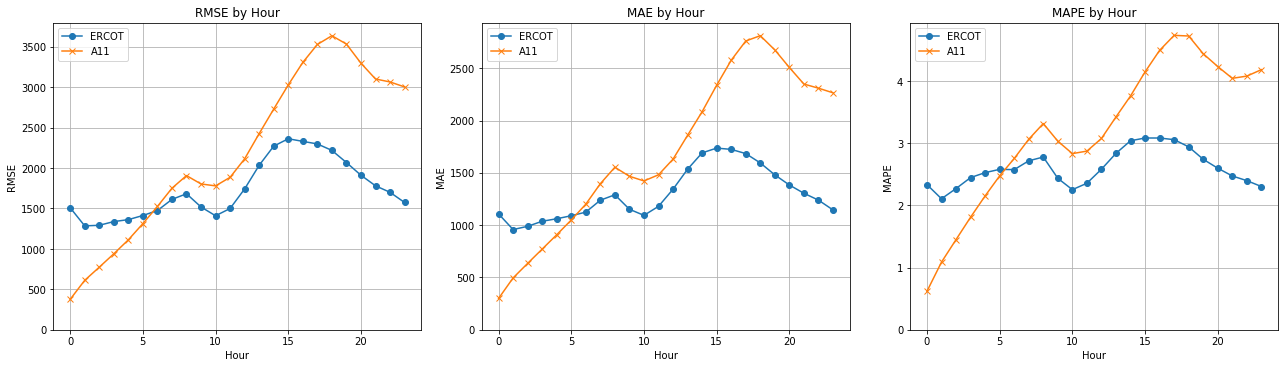

In [5]:
df_metrics = generate_hourly_metrics("../model_outputs/small_dataset/A11_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=7,
                       mean=43558.95,
                       std=10011.015,
                       input_days=1,
                       save=False)

Model RMSE: 2394.276169267608
EIA RMSE: 1771.7003102984756
Model MAE: 1765.7810402828152
EIA MAE: 1299.4786533756733
Model MAPE: 3.3196175306808553
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


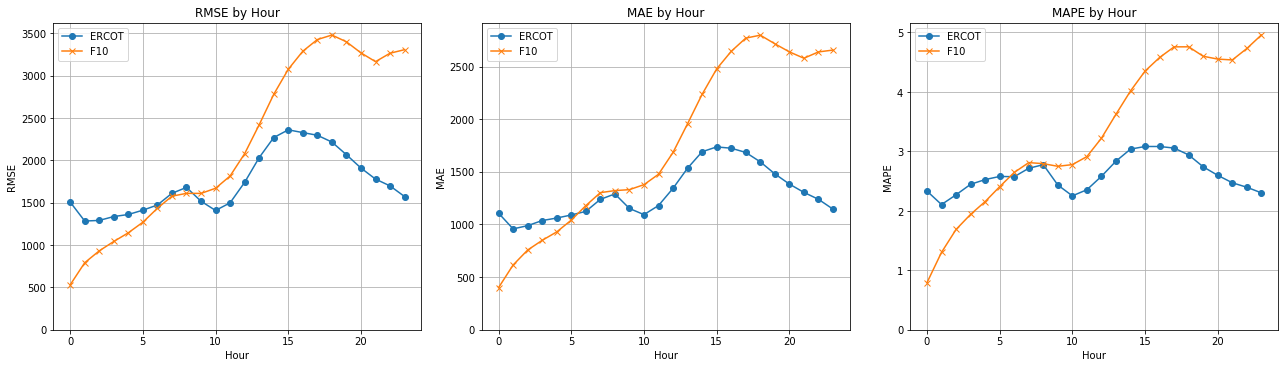

In [37]:
df_metrics = generate_hourly_metrics("../model_outputs/F10_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=6,
                       mean=43558.95,
                       std=10011.015,
                       input_days=7,
                       save=False)

Model RMSE: 2466.5801271654004
EIA RMSE: 1771.7003102984756
Model MAE: 1833.2323916492287
EIA MAE: 1299.4786533756733
Model MAPE: 3.461597413774747
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


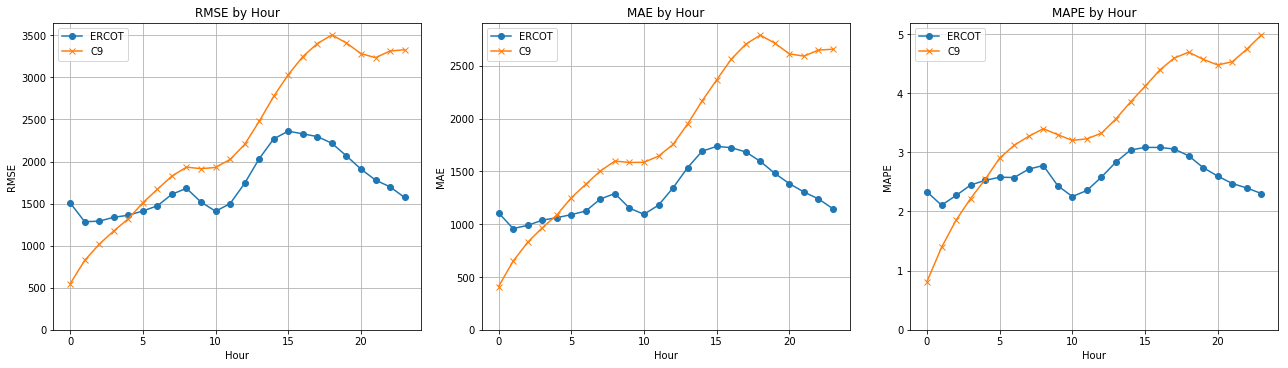

In [16]:
df_metrics = generate_hourly_metrics("../model_outputs/C9_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=6,
                       mean=43558.95,
                       std=10011.015,
                       input_days=2,
                       save=False)

## Shuffle

Model RMSE: 2667.308756250144
EIA RMSE: 1771.7003102984756
Model MAE: 1848.3095524036125
EIA MAE: 1299.4786533756733
Model MAPE: 3.6162434698471193
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


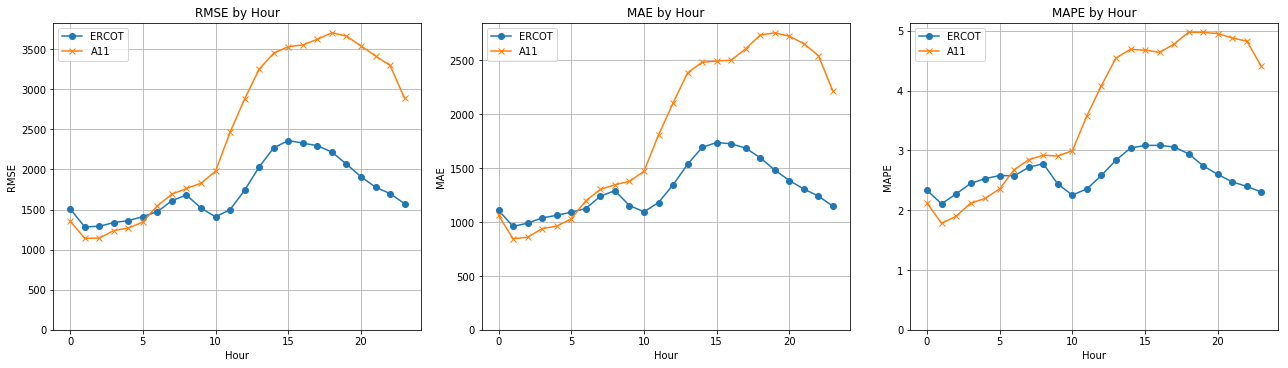

In [26]:
df_metrics = generate_hourly_metrics("../model_outputs/shuffle/A11_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=7,
                       mean=43558.95,
                       std=10011.015,
                       input_days=1,
                       save=False)

## Step size

Model RMSE: 2624.0580859848615
EIA RMSE: 1771.7003102984756
Model MAE: 1830.8952706832251
EIA MAE: 1299.4786533756733
Model MAPE: 3.426252198485048
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


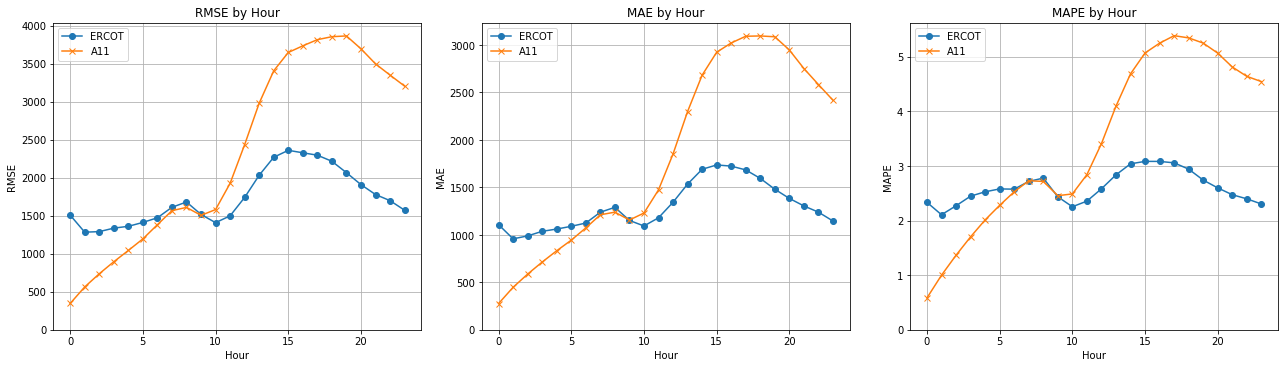

In [41]:
df_metrics = generate_hourly_metrics("../model_outputs/varying_step/A11_s2_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=7,
                       mean=43558.95,
                       std=10011.015,
                       input_days=1,
                       save=False)


Model RMSE: 2183.26241994196
EIA RMSE: 1771.7003102984756
Model MAE: 1662.1638625355972
EIA MAE: 1299.4786533756733
Model MAPE: 3.366640368157398
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


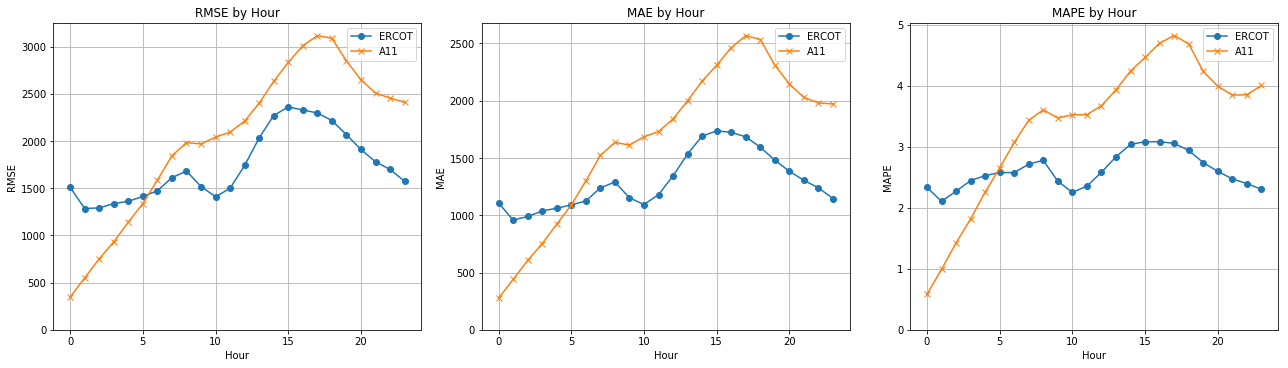

In [31]:
df_metrics = generate_hourly_metrics("../model_outputs/varying_step/A11_s3_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=7,
                       mean=43558.95,
                       std=10011.015,
                       input_days=1,
                       save=False)


Model RMSE: 2381.794765050984
EIA RMSE: 1771.7003102984756
Model MAE: 1646.0742549033434
EIA MAE: 1299.4786533756733
Model MAPE: 3.098599231129157
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


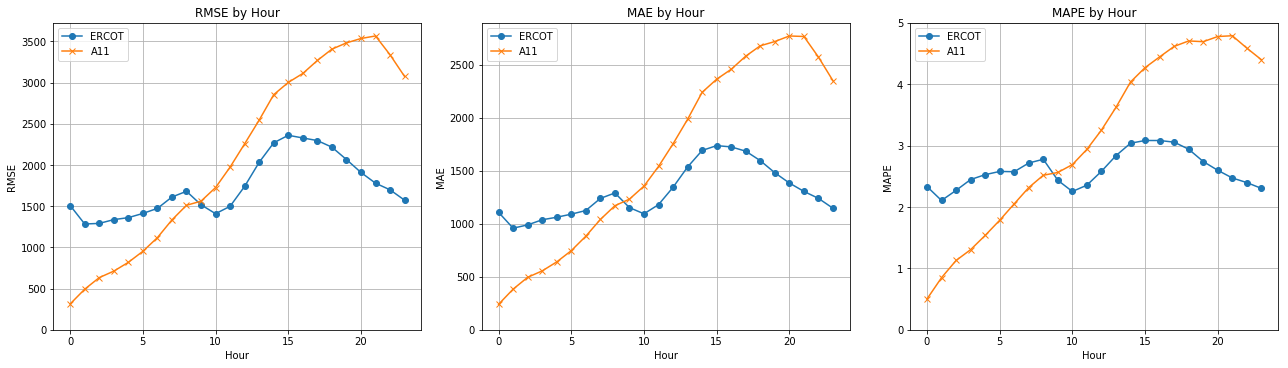

In [32]:
df_metrics = generate_hourly_metrics("../model_outputs/varying_step/A11_s6_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=7,
                       mean=43558.95,
                       std=10011.015,
                       input_days=1,
                       save=False)


Model RMSE: 3657.475203669692
EIA RMSE: 1771.7003102984756
Model MAE: 2600.122010565657
EIA MAE: 1299.4786533756733
Model MAPE: 4.9108849988431365
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


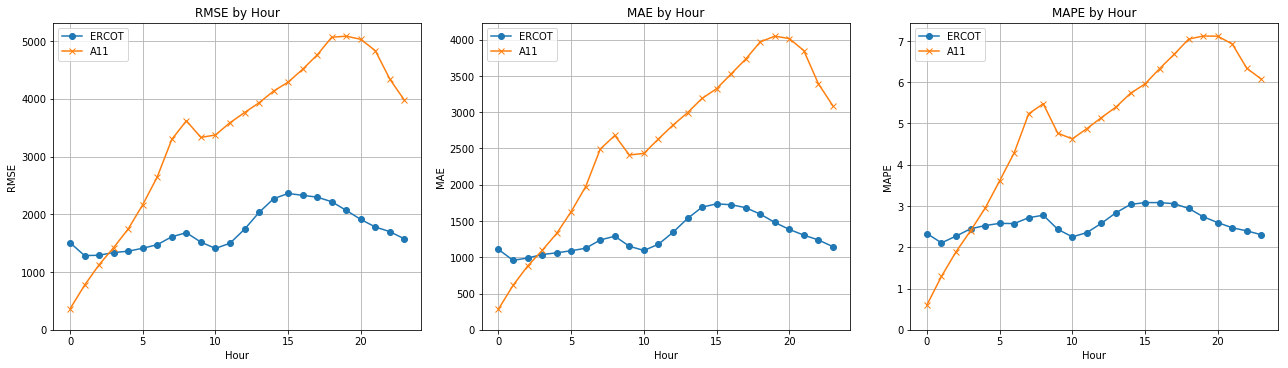

In [40]:
df_metrics = generate_hourly_metrics("../model_outputs/varying_step/A11_s12_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=7,
                       mean=43558.95,
                       std=10011.015,
                       input_days=1,
                       save=False)

Model RMSE: 2936.5752928257607
EIA RMSE: 1771.7003102984756
Model MAE: 2028.5028918118921
EIA MAE: 1299.4786533756733
Model MAPE: 3.9381343159114226
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


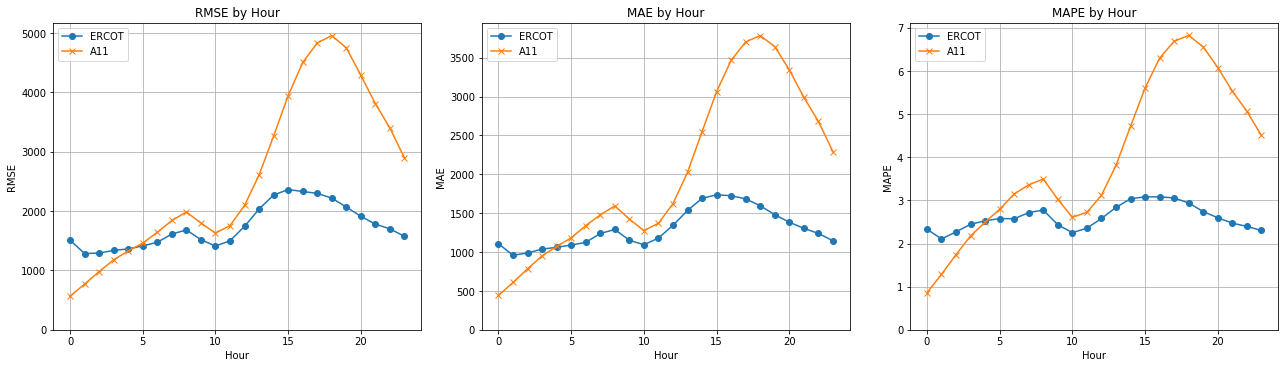

In [34]:
df_metrics = generate_hourly_metrics("../model_outputs/varying_step/A11_s24_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=7,
                       mean=43558.95,
                       std=10011.015,
                       input_days=1,
                       save=False)

Model RMSE: 3506.4869809647253
EIA RMSE: 1771.7003102984756
Model MAE: 2681.7094490498953
EIA MAE: 1299.4786533756733
Model MAPE: 5.186331489710989
EIA MAPE: 2.604292160590841


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


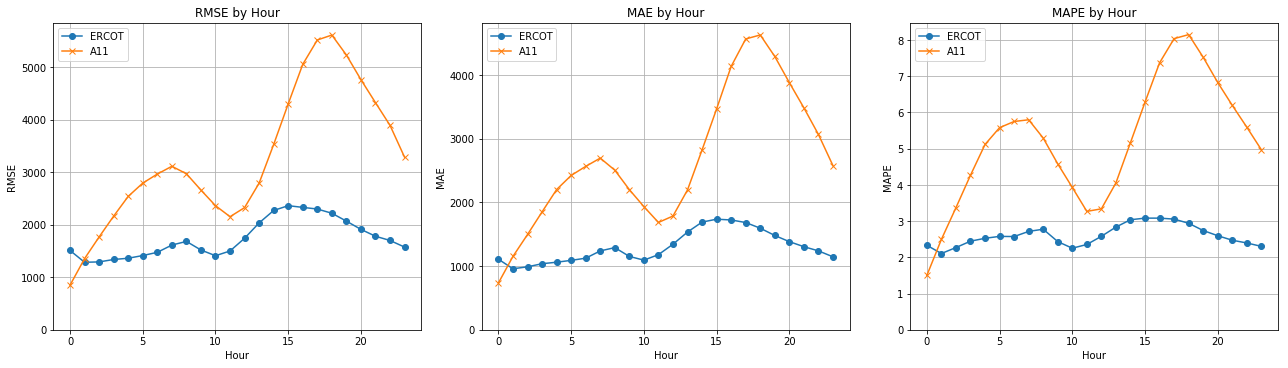

In [42]:
df_metrics = generate_hourly_metrics("../model_outputs/varying_step/A11_s48_erco_2023_example_outputs.json",
                       months=[0,1,2,3,4,5,6,7,8,9,10,11],
                       days=[0,1,2,3,4,5,6],
                       month_idx=7,
                       mean=43558.95,
                       std=10011.015,
                       input_days=1,
                       save=False)

# BasicNet Results

## Short Dataset

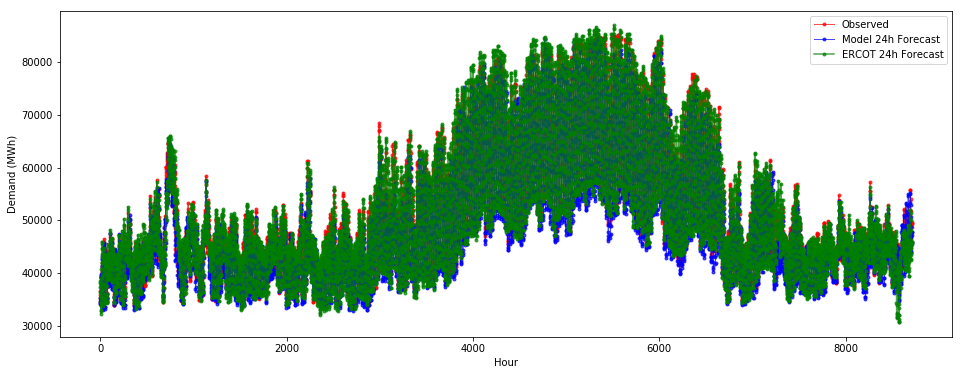

Model RMSE: 2372.9780931417563
Model MAE: 1849.1988779021804
Model MAPE: 3.5310250644853816


In [8]:
# GET RMSE
path = "../model_outputs/small_dataset/basic_linear_short_24_example_outputs.json"
mean=43558.95
std=10011.015

eia_data = pd.read_csv("../data/final_tables/erco_2023_andcomposite/erco_2023_andcomposite.csv")
data_2023 = eia_data[(eia_data["2023"]==1) & (eia_data["year"]==2023)]  
eia_forecast_data = data_2023["Demand Forecast (MWh)"].tolist()

a11_preds = pd.read_csv(
    "/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/thesis2/model_outputs/A11_2023_preds.csv"
)['predicted'][:-48]


observed = []
predicted = []
basicnet_month_preds = {}
ercot_month_preds = {}
a11_month_preds = {}
month_actuals = {}
with open(path, 'r') as file:
    data = json.load(file)
    for i in range(len(data['source_readings'])):
        expected_ex = data['expected'][i][0]
        predicted_ex = data['predicted'][i][0]
#         print(data['source_readings'][i])
        observed += expected_ex
        predicted += predicted_ex

    predicted = np.array(predicted)*std+mean
    observed= np.array(observed)*std+mean
    
    eia_forecast_data=eia_forecast_data[:len(predicted)]
    
    start=24*31*2
    predicted = predicted#[start:start+24*41]
    observed = observed#[start:start+24*41]
    eia_forecast_data=eia_forecast_data#[start:start+24*41]
    
    plt.figure(figsize=(16, 6))  # Set the figure size for better visibility
    plt.plot(observed,linestyle='-', c='r', marker='.', linewidth=1, alpha=0.7, label="Observed")
    plt.plot(predicted,linestyle='-', c='b', marker='.', linewidth=1, alpha=0.7, label="Model 24h Forecast")
    plt.plot(eia_forecast_data,linestyle='-', c='g', marker='.', alpha=0.7, label="ERCOT 24h Forecast")
    plt.xlabel('Hour')
    plt.ylabel('Demand (MWh)')
    plt.legend()

    plt.show()

    model_rmse = rmse(predicted, observed)
    eia_rmse = rmse(eia_forecast_data, observed)
    model_mae = mean_absolute_error(predicted, observed)
    eia_mae = mean_absolute_error(eia_forecast_data, observed)
    model_mape = mape(observed, predicted)
    eia_mape = mape(observed, eia_forecast_data)
    
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31,30,29]
    
    hours_before=0
    for i, days in enumerate(days_per_month):
        basicnet_month_preds[i] = predicted[hours_before:hours_before+days*24]
        ercot_month_preds[i]=eia_forecast_data[hours_before:hours_before+days*24]
        a11_month_preds[i]=a11_preds[hours_before:hours_before+days*24]
        month_actuals[i] = observed[hours_before:hours_before+days*24]
        hours_before+=days*24
        

    print(f"Model RMSE: {model_rmse}")
#     print(f"EIA RMSE: {eia_rmse}")
    print(f"Model MAE: {model_mae}")
#     print(f"EIA MAE: {eia_mae}")
    print(f"Model MAPE: {model_mape}")
#     print(f"EIA MAPE: {eia_mape}")


## T=48

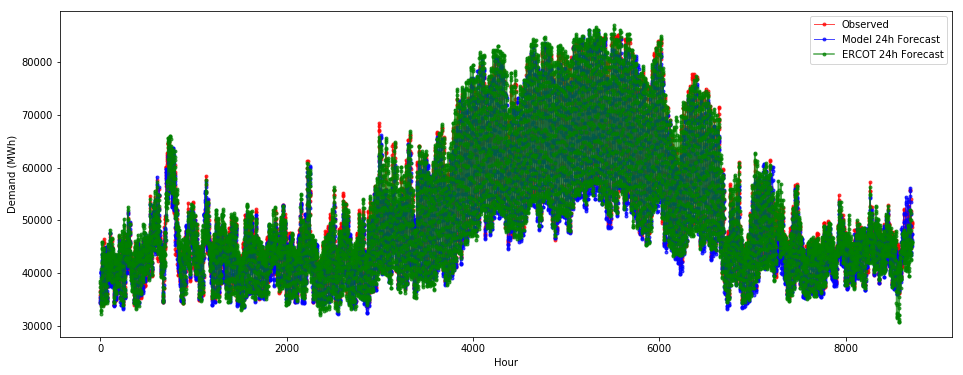

Model RMSE: 1800.9823008002636
Model MAE: 1379.5707819402373
Model MAPE: 2.684521944366277


In [9]:
# GET RMSE
path = "../model_outputs/varying_T/basic_linear_48_example_outputs.json"
mean=43558.95
std=10011.015

eia_data = pd.read_csv("../data/final_tables/erco_2023_andcomposite/erco_2023_andcomposite.csv")
data_2023 = eia_data[(eia_data["2023"]==1) & (eia_data["year"]==2023)]  
eia_forecast_data = data_2023["Demand Forecast (MWh)"].tolist()

a11_preds = pd.read_csv(
    "/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/thesis2/model_outputs/A11_2023_preds.csv"
)['predicted'][:-48]


observed = []
predicted = []
basicnet_month_preds = {}
ercot_month_preds = {}
a11_month_preds = {}
month_actuals = {}
with open(path, 'r') as file:
    data = json.load(file)
    for i in range(len(data['source_readings'])):
        expected_ex = data['expected'][i][0]
        predicted_ex = data['predicted'][i][0]
#         print(data['source_readings'][i])
        observed += expected_ex
        predicted += predicted_ex

    predicted = np.array(predicted)*std+mean
    observed= np.array(observed)*std+mean
    
    eia_forecast_data=eia_forecast_data[:len(predicted)]
    
    start=24*31*2
    predicted = predicted#[start:start+24*41]
    observed = observed#[start:start+24*41]
    eia_forecast_data=eia_forecast_data#[start:start+24*41]
    
    plt.figure(figsize=(16, 6))  # Set the figure size for better visibility
    plt.plot(observed,linestyle='-', c='r', marker='.', linewidth=1, alpha=0.7, label="Observed")
    plt.plot(predicted,linestyle='-', c='b', marker='.', linewidth=1, alpha=0.7, label="Model 24h Forecast")
    plt.plot(eia_forecast_data,linestyle='-', c='g', marker='.', alpha=0.7, label="ERCOT 24h Forecast")
    plt.xlabel('Hour')
    plt.ylabel('Demand (MWh)')
    plt.legend()

    plt.show()

    model_rmse = rmse(predicted, observed)
    eia_rmse = rmse(eia_forecast_data, observed)
    model_mae = mean_absolute_error(predicted, observed)
    eia_mae = mean_absolute_error(eia_forecast_data, observed)
    model_mape = mape(observed, predicted)
    eia_mape = mape(observed, eia_forecast_data)
    
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31,30,29]
    
    hours_before=0
    for i, days in enumerate(days_per_month):
        basicnet_month_preds[i] = predicted[hours_before:hours_before+days*24]
        ercot_month_preds[i]=eia_forecast_data[hours_before:hours_before+days*24]
        a11_month_preds[i]=a11_preds[hours_before:hours_before+days*24]
        month_actuals[i] = observed[hours_before:hours_before+days*24]
        hours_before+=days*24
        

    print(f"Model RMSE: {model_rmse}")
#     print(f"EIA RMSE: {eia_rmse}")
    print(f"Model MAE: {model_mae}")
#     print(f"EIA MAE: {eia_mae}")
    print(f"Model MAPE: {model_mape}")
#     print(f"EIA MAPE: {eia_mape}")


## T=168

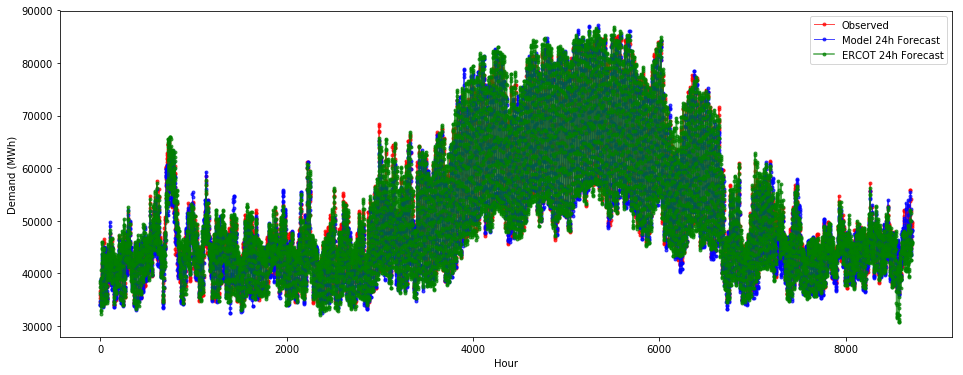

Model RMSE: 1782.8924172351328
Model MAE: 1358.0681440263877
Model MAPE: 2.6753892319808954


In [10]:
# GET RMSE
path = "../model_outputs/varying_T/basic_linear_168_example_outputs.json"
mean=43558.95
std=10011.015

eia_data = pd.read_csv("../data/final_tables/erco_2023_andcomposite/erco_2023_andcomposite.csv")
data_2023 = eia_data[(eia_data["2023"]==1) & (eia_data["year"]==2023)]  
eia_forecast_data = data_2023["Demand Forecast (MWh)"].tolist()

a11_preds = pd.read_csv(
    "/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/thesis2/model_outputs/A11_2023_preds.csv"
)['predicted'][:-48]


observed = []
predicted = []
basicnet_month_preds = {}
ercot_month_preds = {}
a11_month_preds = {}
month_actuals = {}
with open(path, 'r') as file:
    data = json.load(file)
    for i in range(len(data['source_readings'])):
        expected_ex = data['expected'][i][0]
        predicted_ex = data['predicted'][i][0]
#         print(data['source_readings'][i])
        observed += expected_ex
        predicted += predicted_ex

    predicted = np.array(predicted)*std+mean
    observed= np.array(observed)*std+mean
    
    eia_forecast_data=eia_forecast_data[:len(predicted)]
    
    start=24*31*2
    predicted = predicted#[start:start+24*41]
    observed = observed#[start:start+24*41]
    eia_forecast_data=eia_forecast_data#[start:start+24*41]
    
    plt.figure(figsize=(16, 6))  # Set the figure size for better visibility
    plt.plot(observed,linestyle='-', c='r', marker='.', linewidth=1, alpha=0.7, label="Observed")
    plt.plot(predicted,linestyle='-', c='b', marker='.', linewidth=1, alpha=0.7, label="Model 24h Forecast")
    plt.plot(eia_forecast_data,linestyle='-', c='g', marker='.', alpha=0.7, label="ERCOT 24h Forecast")
    plt.xlabel('Hour')
    plt.ylabel('Demand (MWh)')
    plt.legend()

    plt.show()

    model_rmse = rmse(predicted, observed)
    eia_rmse = rmse(eia_forecast_data, observed)
    model_mae = mean_absolute_error(predicted, observed)
    eia_mae = mean_absolute_error(eia_forecast_data, observed)
    model_mape = mape(observed, predicted)
    eia_mape = mape(observed, eia_forecast_data)
    
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31,30,29]
    
    hours_before=0
    for i, days in enumerate(days_per_month):
        basicnet_month_preds[i] = predicted[hours_before:hours_before+days*24]
        ercot_month_preds[i]=eia_forecast_data[hours_before:hours_before+days*24]
        a11_month_preds[i]=a11_preds[hours_before:hours_before+days*24]
        month_actuals[i] = observed[hours_before:hours_before+days*24]
        hours_before+=days*24
        

    print(f"Model RMSE: {model_rmse}")
#     print(f"EIA RMSE: {eia_rmse}")
    print(f"Model MAE: {model_mae}")
#     print(f"EIA MAE: {eia_mae}")
    print(f"Model MAPE: {model_mape}")
#     print(f"EIA MAPE: {eia_mape}")


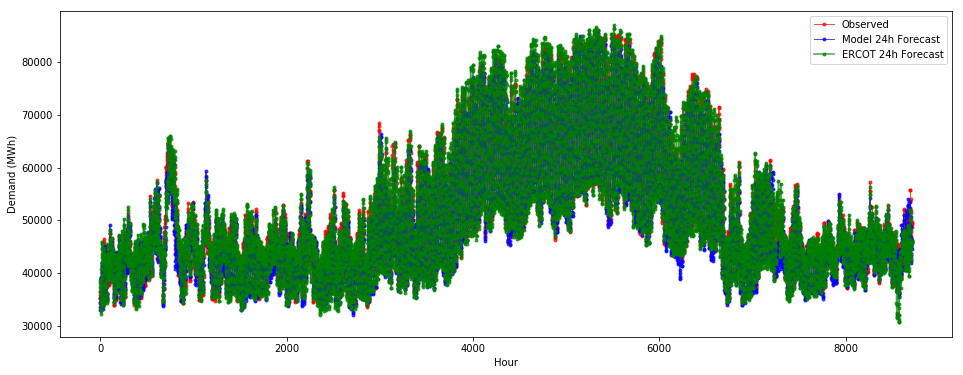

Model RMSE: 1848.9326621853368
Model MAE: 1356.683494174159
Model MAPE: 2.6045175102720868


In [18]:
# GET RMSE
path = "../model_outputs/basic_ercot_2023_example_outputs.json"
mean=43558.95
std=10011.015

eia_data = pd.read_csv("../data/final_tables/erco_2023_andcomposite/erco_2023_andcomposite.csv")
data_2023 = eia_data[(eia_data["2023"]==1) & (eia_data["year"]==2023)]  
eia_forecast_data = data_2023["Demand Forecast (MWh)"].tolist()

a11_preds = pd.read_csv(
    "/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/thesis2/model_outputs/A11_2023_preds.csv"
)['predicted'][:-48]


observed = []
predicted = []
basicnet_month_preds = {}
ercot_month_preds = {}
a11_month_preds = {}
month_actuals = {}
with open(path, 'r') as file:
    data = json.load(file)
    for i in range(len(data['source_readings'])):
        expected_ex = data['expected'][i][0]
        predicted_ex = data['predicted'][i][0]
#         print(data['source_readings'][i])
        observed += expected_ex
        predicted += predicted_ex

    predicted = np.array(predicted)*std+mean
    observed= np.array(observed)*std+mean
    
    eia_forecast_data=eia_forecast_data[:len(predicted)]
    
    start=24*31*2
    predicted = predicted#[start:start+24*41]
    observed = observed#[start:start+24*41]
    eia_forecast_data=eia_forecast_data#[start:start+24*41]
    
    plt.figure(figsize=(16, 6))  # Set the figure size for better visibility
    plt.plot(observed,linestyle='-', c='r', marker='.', linewidth=1, alpha=0.7, label="Observed")
    plt.plot(predicted,linestyle='-', c='b', marker='.', linewidth=1, alpha=0.7, label="Model 24h Forecast")
    plt.plot(eia_forecast_data,linestyle='-', c='g', marker='.', alpha=0.7, label="ERCOT 24h Forecast")
    plt.xlabel('Hour')
    plt.ylabel('Demand (MWh)')
    plt.legend()

    plt.show()

    model_rmse = rmse(predicted, observed)
    eia_rmse = rmse(eia_forecast_data, observed)
    model_mae = mean_absolute_error(predicted, observed)
    eia_mae = mean_absolute_error(eia_forecast_data, observed)
    model_mape = mape(observed, predicted)
    eia_mape = mape(observed, eia_forecast_data)
    
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31,30,29]
    
    hours_before=0
    for i, days in enumerate(days_per_month):
        basicnet_month_preds[i] = predicted[hours_before:hours_before+days*24]
        ercot_month_preds[i]=eia_forecast_data[hours_before:hours_before+days*24]
        a11_month_preds[i]=a11_preds[hours_before:hours_before+days*24]
        month_actuals[i] = observed[hours_before:hours_before+days*24]
        hours_before+=days*24
        

    print(f"Model RMSE: {model_rmse}")
#     print(f"EIA RMSE: {eia_rmse}")
    print(f"Model MAE: {model_mae}")
#     print(f"EIA MAE: {eia_mae}")
    print(f"Model MAPE: {model_mape}")
#     print(f"EIA MAPE: {eia_mape}")


## Shuffle

In [25]:
# GET RMSE
path = "../model_outputs/shuffle/basic_linear_shuffle_24_example_outputs.json"
mean=43558.95
std=10011.015

eia_data = pd.read_csv("../data/final_tables/erco_2023_andcomposite/erco_2023_andcomposite.csv")
data_2023 = eia_data[(eia_data["2023"]==1) & (eia_data["year"]==2023)]  
eia_forecast_data = data_2023["Demand Forecast (MWh)"].tolist()

a11_preds = pd.read_csv(
    "/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/thesis2/model_outputs/A11_2023_preds.csv"
)['predicted'][:-48]


observed = []
predicted = []
basicnet_month_preds = {}
ercot_month_preds = {}
a11_month_preds = {}
month_actuals = {}
with open(path, 'r') as file:
    data = json.load(file)
    for i in range(len(data['source_readings'])):
        expected_ex = data['expected'][i][0]
        predicted_ex = data['predicted'][i][0]
#         print(data['source_readings'][i])
        observed += expected_ex
        predicted += predicted_ex

    predicted = np.array(predicted)*std+mean
    observed= np.array(observed)*std+mean
    
    eia_forecast_data=eia_forecast_data[:len(predicted)]
    
    start=24*31*2
    predicted = predicted#[start:start+24*41]
    

    model_rmse = rmse(predicted, observed)
    model_mae = mean_absolute_error(predicted, observed)
    model_mape = mape(observed, predicted)
    

    print(f"Model RMSE: {model_rmse}")
#     print(f"EIA RMSE: {eia_rmse}")
    print(f"Model MAE: {model_mae}")
#     print(f"EIA MAE: {eia_mae}")
    print(f"Model MAPE: {model_mape}")
#     print(f"EIA MAPE: {eia_mape}")


Model RMSE: 2430.7837144035
Model MAE: 1962.8352989120472
Model MAPE: 3.856466249637913


## Varying Step Size

In [29]:
# GET RMSE
paths = ["../model_outputs/varying_step/basic_linear_s2_T24_example_outputs.json",
         "../model_outputs/varying_step/basic_linear_s3_T24_example_outputs.json",
         "../model_outputs/varying_step/basic_linear_s6_T24_example_outputs.json",
         "../model_outputs/varying_step/basic_linear_s12_T24_example_outputs.json",
         "../model_outputs/varying_step/basic_linear_s24_T24_example_outputs.json",
         "../model_outputs/varying_step/basic_linear_s48_T24_example_outputs.json"
        ]
mean=43558.95
std=10011.015

for path in paths:
    print('-'*24)
    observed = []
    predicted = []
    basicnet_month_preds = {}
    month_actuals = {}
    with open(path, 'r') as file:
        data = json.load(file)
        for i in range(len(data['source_readings'])):
            expected_ex = data['expected'][i][0]
            predicted_ex = data['predicted'][i][0]
            observed += expected_ex
            predicted += predicted_ex

        predicted = np.array(predicted)*std+mean
        observed= np.array(observed)*std+mean

        model_rmse = rmse(predicted, observed)
        model_mae = mean_absolute_error(predicted, observed)
        model_mape = mape(observed, predicted)

        print(f"Model RMSE: {model_rmse}")
        print(f"Model MAE: {model_mae}")
        print(f"Model MAPE: {model_mape}")

------------------------
Model RMSE: 2335.730700651598
Model MAE: 1813.1624429393075
Model MAPE: 3.550216423793958
------------------------
Model RMSE: 2176.5382007156772
Model MAE: 1669.4407287166437
Model MAPE: 3.2645442226611476
------------------------
Model RMSE: 2551.985794305028
Model MAE: 1931.365403690678
Model MAPE: 3.6850168313520206
------------------------
Model RMSE: 2447.971548153728
Model MAE: 1874.1404892615724
Model MAPE: 3.589416405970543
------------------------
Model RMSE: 2067.901733314063
Model MAE: 1518.0691352966403
Model MAPE: 2.901230950562873
------------------------
Model RMSE: 2360.368241916209
Model MAE: 1809.195129229524
Model MAPE: 3.5092921566263326


# Plot of transformer vs basicnet errors across T

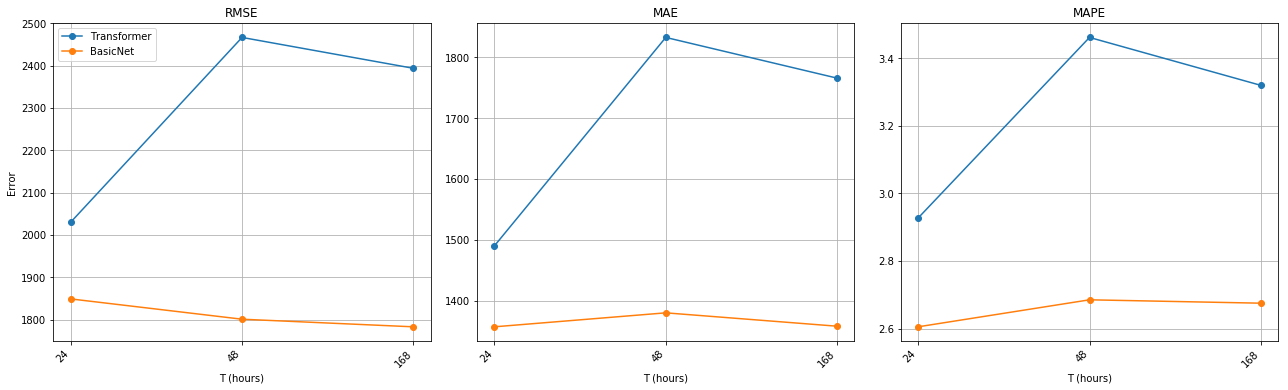

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data in the specified format
errors = {
    24: {
        'Transformer': [2030, 1490, 2.927],
        'BasicNet': [1849, 1357, 2.605]
    },
    48: {
        'Transformer': [2467, 1833, 3.462],
        'BasicNet': [1801, 1380, 2.685]
    },
    168: {
        'Transformer': [2394, 1766, 3.320],
        'BasicNet': [1783, 1358, 2.675]
    }
}



# Making Ts evenly spaced
Ts_indices = np.arange(len(Ts))

# Plotting with individual scales
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, metric in zip(axs, metrics):
    for model in models:
        ax.plot(Ts_indices, data[metric][model], marker='o', label=model)
    ax.set_title(metric)
    ax.set_xticks(Ts_indices)
    ax.set_xticklabels(Ts)
    ax.set_xlabel('T (hours)')
    ax.grid(True)

axs[0].set_ylabel('Error')
fig.autofmt_xdate(rotation=45)
axs[0].legend(loc='upper left')
# plt.suptitle('Error Metrics Across Different Ts for Transformer and BasicNet, with Individual Scales')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(
    f"/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/Homeworks/FinalThesis/Figures/varying_T_errors.pdf", 
    format="pdf", 
    bbox_inches="tight")
plt.show()


# Plot of transformer vs basicnet errors across $s$

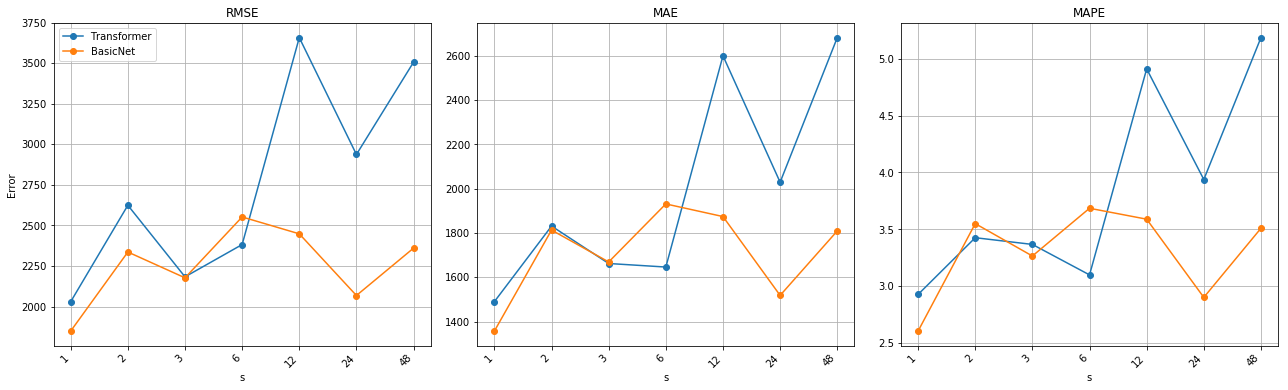

In [43]:
# Assuming data in the specified format
errors = {
    1: {
        'Transformer': [2030, 1490, 2.927],
        'BasicNet': [1849, 1357, 2.605]
    },
    2: {
        'Transformer': [2624, 1831, 3.426 ],
        'BasicNet': [2336, 1813, 3.550]
    },
    3: {
        'Transformer': [2183, 1662, 3.367],
        'BasicNet': [2177, 1669, 3.265]
    },
    6: {
        'Transformer': [2382, 1646, 3.099],
        'BasicNet': [2552, 1931, 3.685]
    },
    12: {
        'Transformer': [3657, 2600, 4.911 ],
        'BasicNet': [2448, 1874, 3.589]
    },
    24: {
        'Transformer': [2937, 2029, 3.938],
        'BasicNet': [2068, 1518, 2.901]
    },
    48: {
        'Transformer': [3506, 2682, 5.186],
        'BasicNet': [2360, 1809, 3.509]
    }
}

# Preparing data for plotting
s_vals = list(errors.keys())
metrics = ['RMSE', 'MAE', 'MAPE']
models = ['Transformer', 'BasicNet']
data = {metric: {model: [] for model in models} for metric in metrics}

for s in s_vals:
    for model in models:
        for i, metric in enumerate(metrics):
            data[metric][model].append(errors[s][model][i])
            

# Making Ts evenly spaced
s_indices = np.arange(len(s_vals))

# Plotting with individual scales
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, metric in zip(axs, metrics):
    for model in models:
        ax.plot(s_indices, data[metric][model], marker='o', label=model)
    ax.set_title(metric)
    ax.set_xticks(s_indices)
    ax.set_xticklabels(s_vals)
    ax.set_xlabel('s')
    ax.grid(True)

axs[0].set_ylabel('Error')
fig.autofmt_xdate(rotation=45)
axs[0].legend(loc='upper left')
# plt.suptitle('Error Metrics Across Different Ts for Transformer and BasicNet, with Individual Scales')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(
    f"/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/Homeworks/FinalThesis/Figures/step_size_errors.pdf", 
    format="pdf", 
    bbox_inches="tight")
plt.show()